In [1]:
import keras

Using TensorFlow backend.


In [2]:
from keras import backend as K
K.get_session().close()
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [3]:
from keras.layers import Conv2DTranspose ,concatenate, Input,Activation ,Conv2D ,BatchNormalization , Dense ,Dropout ,Flatten ,MaxPool2D ,GlobalMaxPool2D ,GlobalAveragePooling2D
from keras.models import Sequential ,Model
from keras.optimizers import Adam

In [4]:
def get_unet():
    inputs = Input((160, 320, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPool2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(4, (1, 1))(conv9)
    conv11 =GlobalAveragePooling2D()(conv10)
    conv12 =     Activation('softmax') (conv11)
    model = Model(inputs=[inputs], outputs=[conv12])

  

    model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [5]:
model=get_unet()

In [6]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 160, 320, 1)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 160, 320, 32)  320         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 160, 320, 32)  9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 80, 160, 32)   0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
gen=image.ImageDataGenerator( rotation_range=15,shear_range=0.1 ,channel_shift_range=0.2 ,width_shift_range=0.4 , height_shift_range=0.25)
gen1=image.ImageDataGenerator()

In [8]:
batch_size=30

train= gen.flow_from_directory('train', target_size=(160,320),
                class_mode='categorical', shuffle=True, batch_size=batch_size, color_mode='grayscale')

Found 5820 images belonging to 4 classes.


In [9]:
val= gen1.flow_from_directory('val', target_size=(160,320),
                class_mode='categorical', shuffle=False, batch_size=batch_size, color_mode='grayscale')

Found 1098 images belonging to 4 classes.


In [10]:
from keras.optimizers import Adam
model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
batch_size=30
model.fit_generator(train, steps_per_epoch=5820 /batch_size, epochs=1, 
                            validation_data=val, validation_steps=1098 /batch_size)

Epoch 1/1
194/194 [==============================] - 120s - loss: 1.3429 - acc: 0.3505 - val_loss: 1.3837 - val_acc: 0.2732


In [31]:
model.optimizer.lr=0.1
for i in range (1,4):
    model.fit_generator(train, steps_per_epoch=5820/batch_size, epochs=5, 
                            validation_data=val, validation_steps=1098/batch_size)
    model.save_weights ('unet{x}.h5'.format(x=i))

Epoch 1/5
194/194 [==============================] - 119s - loss: 1.3438 - acc: 0.3656 - val_loss: 1.3903 - val_acc: 0.2741
Epoch 2/5
194/194 [==============================] - 113s - loss: 1.3327 - acc: 0.3723 - val_loss: 1.3627 - val_acc: 0.2769
Epoch 3/5
194/194 [==============================] - 116s - loss: 1.3263 - acc: 0.3794 - val_loss: 1.3280 - val_acc: 0.3297
Epoch 4/5
194/194 [==============================] - 114s - loss: 1.3150 - acc: 0.3868 - val_loss: 1.3869 - val_acc: 0.2787
Epoch 5/5
194/194 [==============================] - 115s - loss: 1.2993 - acc: 0.4096 - val_loss: 1.3362 - val_acc: 0.3197
Epoch 1/5
194/194 [==============================] - 117s - loss: 1.2911 - acc: 0.4124 - val_loss: 1.3271 - val_acc: 0.3233
Epoch 2/5
194/194 [==============================] - 114s - loss: 1.2704 - acc: 0.4223 - val_loss: 1.2876 - val_acc: 0.3434
Epoch 3/5
194/194 [==============================] - 111s - loss: 1.2565 - acc: 0.4294 - val_loss: 1.2623 - val_acc: 0.3807
Epoch 4/

In [32]:
model.optimizer.lr=0.01
for i in range (4,7):
    model.fit_generator(train, steps_per_epoch=5820/batch_size, epochs=5, 
                            validation_data=val, validation_steps=1098/batch_size)
    model.save_weights ('unet{x}.h5'.format(x=i))

Epoch 1/5
194/194 [==============================] - 118s - loss: 1.1432 - acc: 0.4969 - val_loss: 1.4787 - val_acc: 0.3106
Epoch 2/5
194/194 [==============================] - 113s - loss: 1.1402 - acc: 0.5031 - val_loss: 1.4461 - val_acc: 0.3160
Epoch 3/5
194/194 [==============================] - 112s - loss: 1.1386 - acc: 0.5053 - val_loss: 1.3670 - val_acc: 0.3479
Epoch 4/5
194/194 [==============================] - 108s - loss: 1.1131 - acc: 0.5163 - val_loss: 1.3865 - val_acc: 0.3470
Epoch 5/5
194/194 [==============================] - 112s - loss: 1.1223 - acc: 0.5062 - val_loss: 1.4073 - val_acc: 0.3370
Epoch 1/5
194/194 [==============================] - 113s - loss: 1.1040 - acc: 0.5208 - val_loss: 1.5595 - val_acc: 0.3197
Epoch 2/5
194/194 [==============================] - 108s - loss: 1.1035 - acc: 0.5192 - val_loss: 1.3910 - val_acc: 0.3370
Epoch 3/5
194/194 [==============================] - 109s - loss: 1.1037 - acc: 0.5280 - val_loss: 1.4633 - val_acc: 0.3169
Epoch 4/

In [33]:
model.optimizer.lr=0.001
for i in range (7,10):
    model.fit_generator(train, steps_per_epoch=5820/batch_size, epochs=5, 
                            validation_data=val, validation_steps=1098/batch_size)
    model.save_weights ('unet{x}.h5'.format(x=i))

Epoch 1/5
194/194 [==============================] - 117s - loss: 1.0609 - acc: 0.5440 - val_loss: 1.4952 - val_acc: 0.3060
Epoch 2/5
194/194 [==============================] - 113s - loss: 1.0609 - acc: 0.5454 - val_loss: 1.5450 - val_acc: 0.2942
Epoch 3/5
194/194 [==============================] - 109s - loss: 1.0402 - acc: 0.5483 - val_loss: 1.6119 - val_acc: 0.3069
Epoch 4/5
194/194 [==============================] - 109s - loss: 1.0508 - acc: 0.5531 - val_loss: 1.5072 - val_acc: 0.3151
Epoch 5/5
194/194 [==============================] - 113s - loss: 1.0360 - acc: 0.5546 - val_loss: 1.5254 - val_acc: 0.3260
Epoch 1/5
194/194 [==============================] - 116s - loss: 1.0326 - acc: 0.5629 - val_loss: 1.5164 - val_acc: 0.3042
Epoch 2/5
194/194 [==============================] - 106s - loss: 1.0210 - acc: 0.5581 - val_loss: 1.6052 - val_acc: 0.3151
Epoch 3/5
194/194 [==============================] - 107s - loss: 1.0209 - acc: 0.5660 - val_loss: 1.5101 - val_acc: 0.3033
Epoch 4/

In [34]:
model.optimizer.lr=0.0001
for i in range (10,13):
    model.fit_generator(train, steps_per_epoch=5820/batch_size, epochs=5, 
                            validation_data=val, validation_steps=1098/batch_size)
    model.save_weights ('unet{x}.h5'.format(x=i))

Epoch 1/5
194/194 [==============================] - 110s - loss: 0.9774 - acc: 0.5905 - val_loss: 1.6407 - val_acc: 0.2814
Epoch 2/5
194/194 [==============================] - 108s - loss: 0.9587 - acc: 0.5895 - val_loss: 1.5299 - val_acc: 0.3179
Epoch 3/5
194/194 [==============================] - 108s - loss: 0.9491 - acc: 0.5904 - val_loss: 1.5807 - val_acc: 0.3142
Epoch 4/5
194/194 [==============================] - 109s - loss: 0.9640 - acc: 0.5878 - val_loss: 1.6603 - val_acc: 0.3015
Epoch 5/5
194/194 [==============================] - 111s - loss: 0.9243 - acc: 0.6084 - val_loss: 1.7420 - val_acc: 0.2987
Epoch 1/5
194/194 [==============================] - 113s - loss: 0.9442 - acc: 0.5976 - val_loss: 1.6757 - val_acc: 0.3069
Epoch 2/5
194/194 [==============================] - 110s - loss: 0.9274 - acc: 0.6089 - val_loss: 1.6148 - val_acc: 0.2923
Epoch 3/5
194/194 [==============================] - 111s - loss: 0.9379 - acc: 0.6052 - val_loss: 1.5348 - val_acc: 0.3087
Epoch 4/

In [35]:
model.optimizer.lr=0.00001
for i in range (13,16):
    model.fit_generator(train, steps_per_epoch=5820/batch_size, epochs=5, 
                            validation_data=val, validation_steps=1098/batch_size)
    model.save_weights ('unet{x}.h5'.format(x=i))

Epoch 1/5
194/194 [==============================] - 117s - loss: 0.9003 - acc: 0.6187 - val_loss: 1.8982 - val_acc: 0.2823
Epoch 2/5
194/194 [==============================] - 111s - loss: 0.8735 - acc: 0.6285 - val_loss: 1.8800 - val_acc: 0.2814
Epoch 3/5
194/194 [==============================] - 112s - loss: 0.8850 - acc: 0.6265 - val_loss: 1.6769 - val_acc: 0.2842
Epoch 4/5
194/194 [==============================] - 108s - loss: 0.8522 - acc: 0.6383 - val_loss: 1.8005 - val_acc: 0.2896
Epoch 5/5
194/194 [==============================] - 109s - loss: 0.8613 - acc: 0.6332 - val_loss: 1.8534 - val_acc: 0.2805
Epoch 1/5
194/194 [==============================] - 111s - loss: 0.8589 - acc: 0.6349 - val_loss: 1.9087 - val_acc: 0.2823
Epoch 2/5
194/194 [==============================] - 108s - loss: 0.8561 - acc: 0.6442 - val_loss: 1.7552 - val_acc: 0.2923
Epoch 3/5
194/194 [==============================] - 112s - loss: 0.8400 - acc: 0.6426 - val_loss: 1.6871 - val_acc: 0.2923
Epoch 4/

In [12]:
model.optimizer.lr=0.00001
for i in range (20,30):
    model.fit_generator(train, steps_per_epoch=5820/batch_size, epochs=5, 
                            validation_data=val, validation_steps=1098/batch_size)
    model.save_weights ('unet_{x}.h5'.format(x=i))

Epoch 1/5
194/194 [==============================] - 126s - loss: 0.7539 - acc: 0.6871 - val_loss: 2.1210 - val_acc: 0.2641
Epoch 2/5
194/194 [==============================] - 118s - loss: 0.7586 - acc: 0.6789 - val_loss: 2.0729 - val_acc: 0.2568
Epoch 3/5
194/194 [==============================] - 116s - loss: 0.7425 - acc: 0.6919 - val_loss: 2.0050 - val_acc: 0.2486
Epoch 4/5
194/194 [==============================] - 112s - loss: 0.7361 - acc: 0.6950 - val_loss: 2.2576 - val_acc: 0.2614
Epoch 5/5
194/194 [==============================] - 112s - loss: 0.7402 - acc: 0.6928 - val_loss: 2.4705 - val_acc: 0.2459
Epoch 1/5
194/194 [==============================] - 116s - loss: 0.7499 - acc: 0.6893 - val_loss: 2.1738 - val_acc: 0.2559
Epoch 2/5
194/194 [==============================] - 108s - loss: 0.7344 - acc: 0.7009 - val_loss: 2.1722 - val_acc: 0.2760
Epoch 3/5
194/194 [==============================] - 109s - loss: 0.7380 - acc: 0.6923 - val_loss: 2.5470 - val_acc: 0.2514
Epoch 4/

KeyboardInterrupt: 

In [13]:
model.load_weights ('unet_23.h5')

In [14]:
test = gen1.flow_from_directory('test', target_size=(160,320),
                class_mode='categorical', shuffle=False, batch_size=1 ,color_mode='grayscale')

Found 200 images belonging to 4 classes.


In [15]:
pre=model.predict_generator(test,200)

In [16]:
files = test.filenames

In [17]:
mistake=0
doubt=0
file=[]
file1=[]
correct=0
num=0
for x in pre :
    
    if x[0]<0.8 and x[0]>0.2: 
        doubt+=1
        print (x , "doubt")
        file1.append (files[num])
    else:
        if num<120:
            if x[0]<0.8: 
                mistake+=1
                print (x,num)
                file.append (files[num])
            else : correct+=1
        else:
            if x[1]<0.8: 
                mistake+=1
                print (x,num) 
                file.append (files[num])
            else : correct+=1
    num+=1
    
all=correct+mistake

[ 0.18582053  0.01609936  0.45854974  0.33953038] 0
[ 0.23399843  0.03474998  0.32247603  0.40877554] doubt
[ 0.08936381  0.0079674   0.68378145  0.21888736] 2
[ 0.01522608  0.03715307  0.0350131   0.91260773] 3
[ 0.04532599  0.00182005  0.89634246  0.05651157] 4
[ 0.01819958  0.00120039  0.93133467  0.04926534] 5
[ 0.02303479  0.00150377  0.88918531  0.08627607] 6
[ 0.01646493  0.45856234  0.05663238  0.46834037] 7
[  5.71872108e-04   1.33163920e-02   3.93682113e-03   9.82174933e-01] 8
[ 0.08886485  0.01393925  0.36999887  0.52719706] 9
[ 0.01633641  0.00105092  0.9151327   0.0674799 ] 10
[  7.37728493e-04   3.32957110e-03   1.67218538e-03   9.94260550e-01] 11
[ 0.00162095  0.02959012  0.01078815  0.95800072] 12
[  1.44769242e-02   7.08610285e-04   9.42327082e-01   4.24873456e-02] 13
[  2.19785478e-02   8.56242608e-04   9.41098869e-01   3.60663384e-02] 14
[  2.98242061e-03   8.68963063e-01   1.28037512e-01   1.69681389e-05] 15
[ 0.01968696  0.00098871  0.93199587  0.04732844] 16
[ 0.0

In [18]:
correct/all

0.12931034482758622

In [19]:
doubt/all

0.7241379310344828

In [20]:
mistake

101

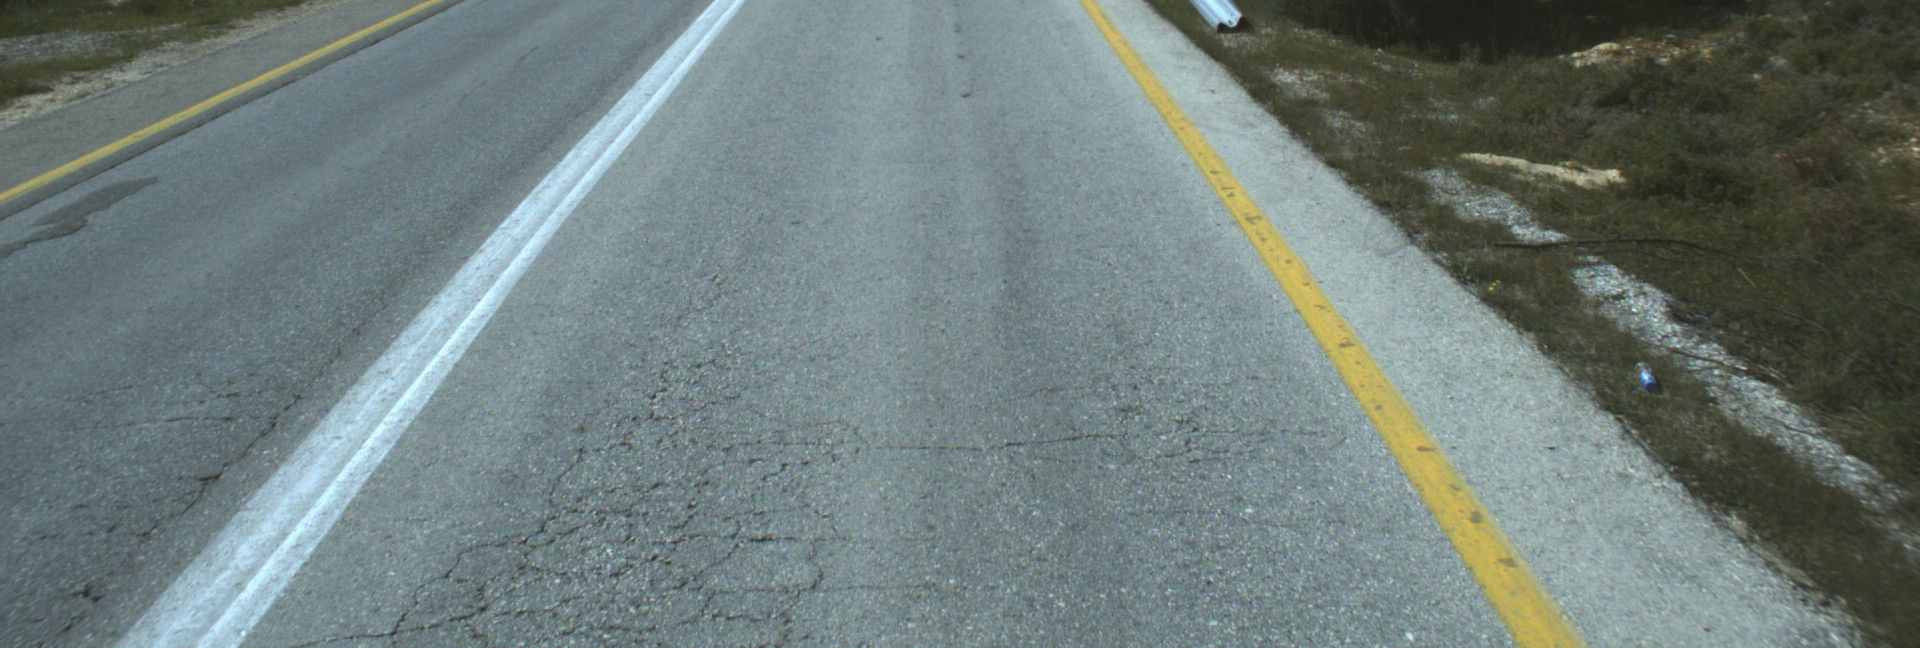

In [85]:
image.load_img ('test/'+files[120])

In [21]:
test = gen1.flow_from_directory('test', target_size=(160,320),
                class_mode=None, shuffle=False, batch_size=1 , color_mode='grayscale')

Found 200 images belonging to 4 classes.


In [22]:
import numpy as np
test1=np.concatenate([test.next() for i in range(test.samples)])

In [23]:
from matplotlib import pyplot as plt

def plot(img):
    plt.imshow(to_plot(img))


def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
def to_plot(img):
    if K.image_dim_ordering() == 'tf':
        return np.rollaxis(img, 0, 1).astype(np.uint8)
    else:
        return np.rollaxis(img, 0, 3).astype(np.uint8)

In [24]:
%matplotlib inline

In [153]:
from keras import backend as K
l =model.layers
conv_fn = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[-8].output])

In [154]:
test.class_indices

{'al': 0, 'bl': 1, 'lotr': 2, 'ra': 3}

In [155]:
pic=31

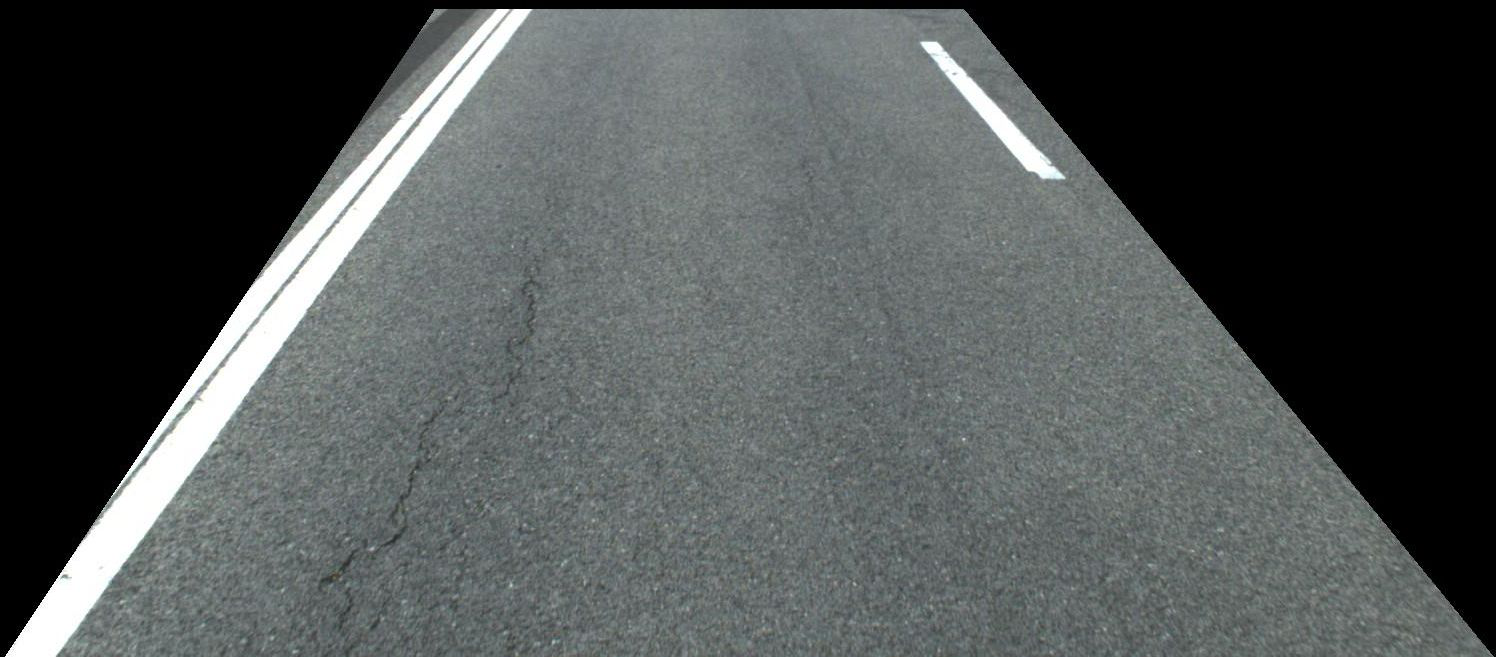

In [156]:
image.load_img ('test/'+files[pic])

In [157]:
pre [pic]

array([  1.46107937e-04,   1.27457812e-01,   1.98991550e-03,
         8.70406151e-01], dtype=float32)

In [158]:

inp = np.expand_dims(test1[pic], 0)
conv = conv_fn([inp,0])
conv=conv[0]
print (conv.shape)
show=np.swapaxes(conv,2,3)
show=np.swapaxes(show,1,2)
show=show[0]
print (show.shape)

(1, 80, 160, 64)
(64, 80, 160)


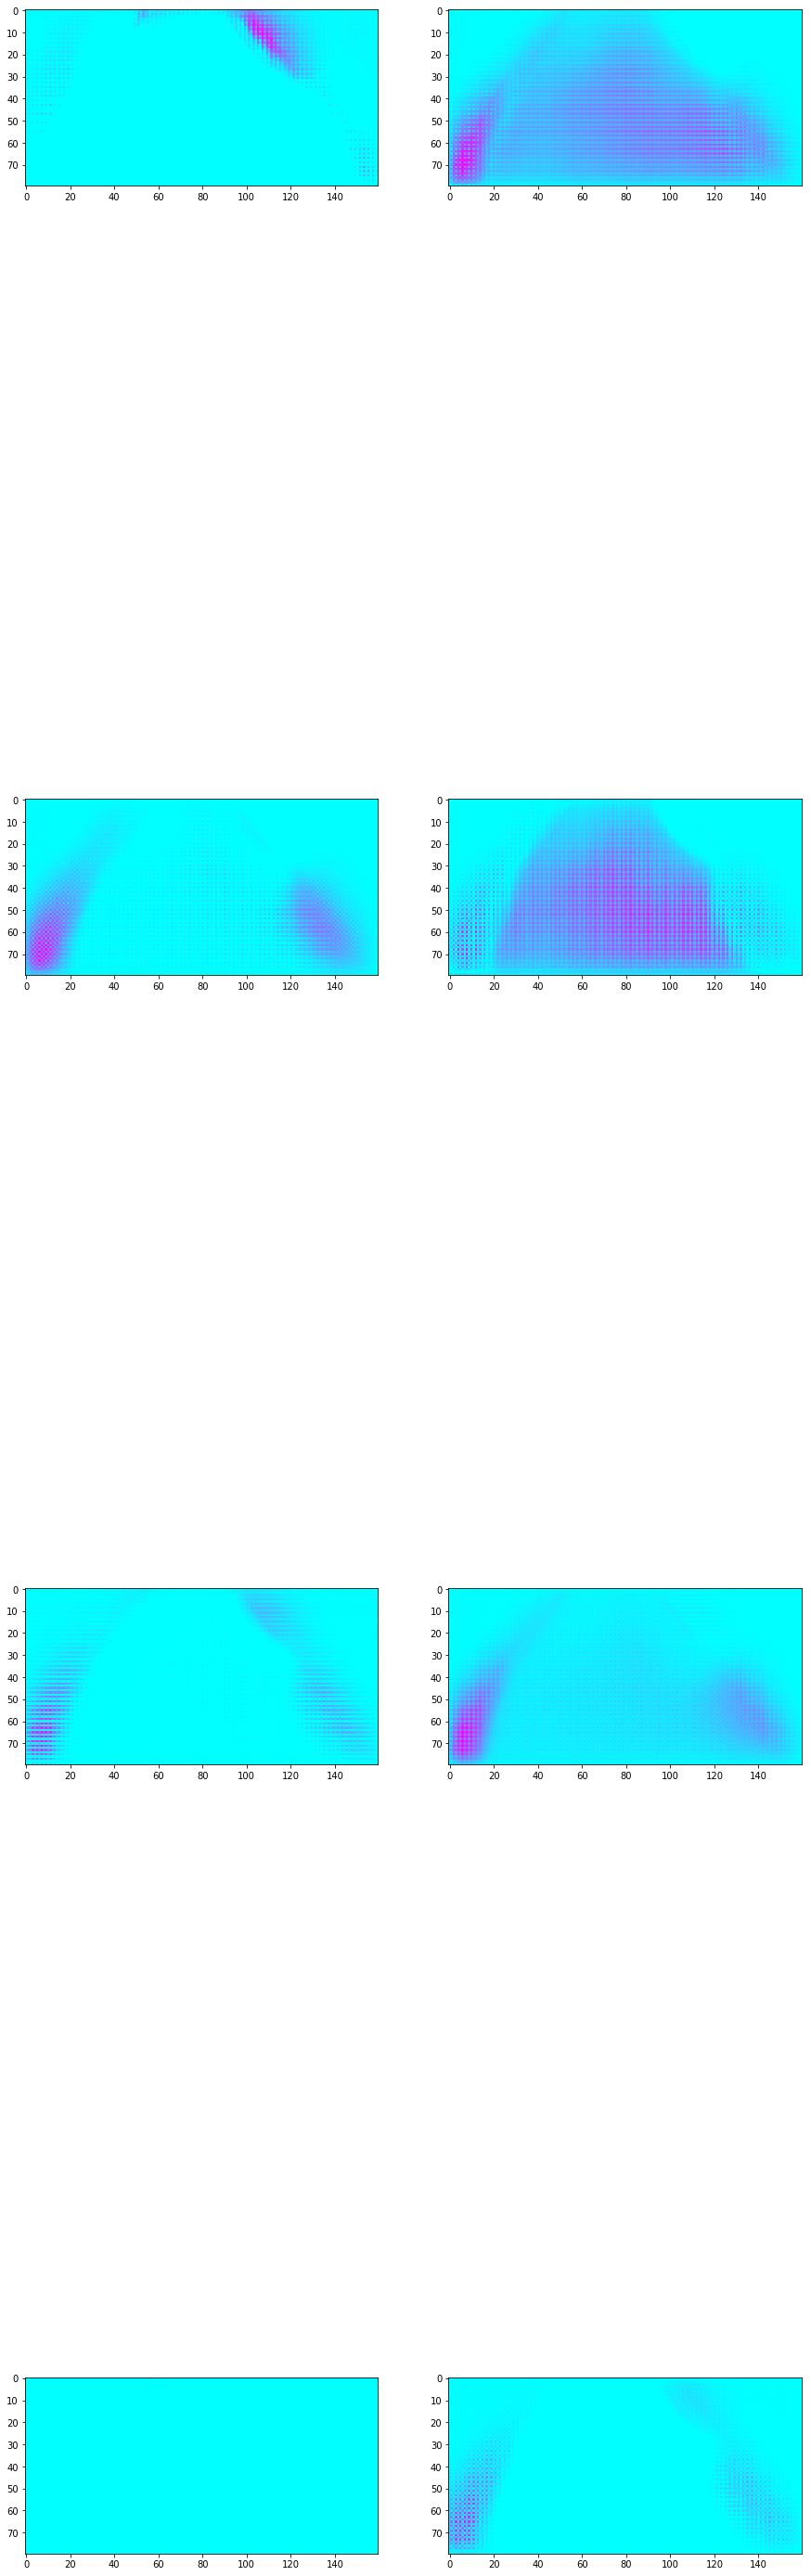

In [167]:
num=57
plt.subplots(figsize=(15, 60))
for i in range (1,9):
    plt.subplot(4, 2, i )
    plt.imshow (show[num-1] , cmap="cool") 
    num+=1

(160, 320)


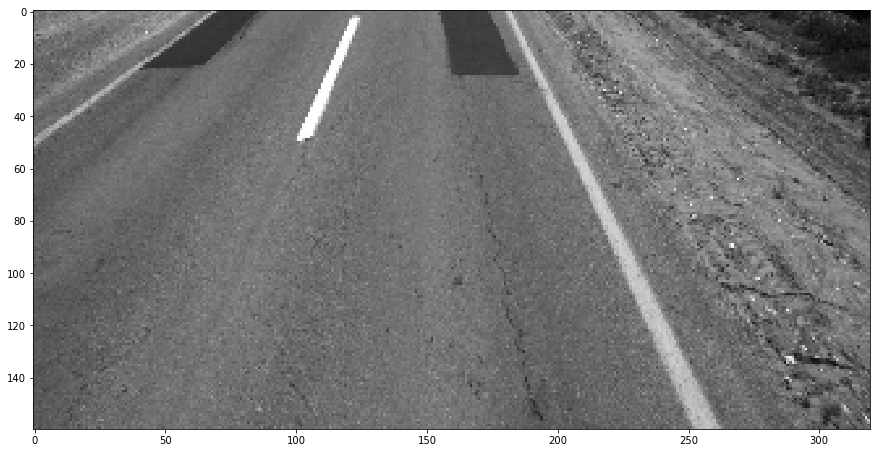

In [121]:
plt.figure(figsize=(15,15))
plt.imshow (x ,cmap="gray")

In [122]:
x=np.reshape (test1[pic] , (160,320))

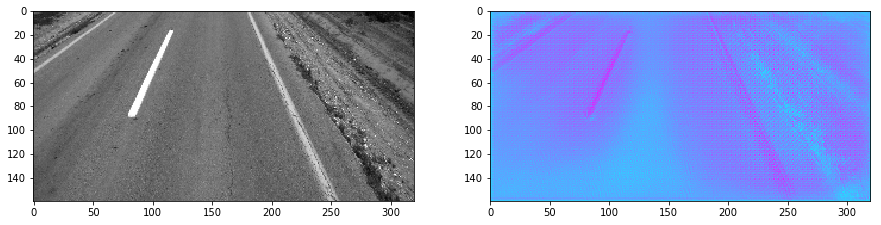

In [123]:
plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow (x ,cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow (show , cmap="cool") 

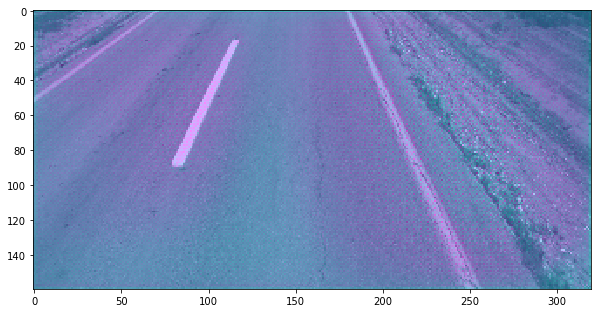

In [124]:
plt.figure(figsize=(10,10))
plt.imshow(x ,cmap="gray", alpha=1)
plt.imshow(show, cmap="cool", alpha=0.5)

In [39]:
x[0][1]**0.1

array([[[ 1.68726838],
        [ 1.69521821],
        [ 1.69084322],
        ..., 
        [ 1.47875762],
        [ 1.51806843],
        [ 1.54400635]],

       [[ 1.69435132],
        [ 1.68726838],
        [ 1.66322684],
        ..., 
        [ 1.6926055 ],
        [ 1.70117736],
        [ 1.58330107]],

       [[ 1.69608116],
        [ 1.67802072],
        [ 1.65802073],
        ..., 
        [ 1.68545508],
        [ 1.68636394],
        [ 1.6926055 ]],

       ..., 
       [[ 1.47875762],
        [ 1.47875762],
        [ 1.45662189],
        ..., 
        [ 1.52493346],
        [ 1.53579164],
        [ 1.52267599]],

       [[ 1.47273338],
        [ 1.47875762],
        [ 1.46647882],
        ..., 
        [ 1.51806843],
        [ 1.52038789],
        [ 1.5315311 ]],

       [[ 1.48168886],
        [ 1.47875762],
        [ 1.48168886],
        ..., 
        [ 1.51806843],
        [ 1.51806843],
        [ 1.52267599]]], dtype=float32)

In [87]:
x=val.next()

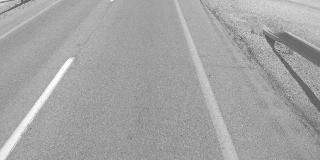

In [94]:
image.array_to_img((x[0][8]/255)**0.5)